In [127]:
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.misc import imshow
import sys
sys.path.insert(0, '../../LEARNING/tensorflow/')
sys.path.insert(0, '../../LEARNING/PCA_dl/')
from Dataset import DatasetNoLabel, Dataset
from layers import full_connected

In [128]:
data = pd.read_csv('./inputs/train.csv').values[:, 1:].reshape(-1, 28, 28, 1)
label = pd.read_csv('./inputs/train.csv').values[:, 0]

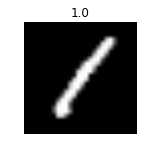

In [189]:
def showimg(imgdata, title=None, figsize=(2, 2), shape=(28, 28)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(imgdata.reshape(shape))
    plt.gray()
    plt.axis('off')
    if title != None:
        plt.title(title)

    plt.show()
# test
showimg(data[0], label[0])

In [130]:
def weight_variable(shape, name=None):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)

def bias_variable(shape, name=None):
    return tf.Variable(tf.constant(0.1, shape = shape), name)

def conv2d(x, W, b, padding='SAME', activation='relu'):
    conv = tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding=padding)
    if activation == 'relu':
        return tf.nn.relu(conv+b)
    if activation == 'sigmoid':
        return tf.nn.sigmoid(conv+b)
    if activation == 'tanh':
        return tf.nn.tanh(conv+b)
    
def deconv2d(x, W, output_shape, activation='relu'):
    if activation == None:
        return tf.nn.conv2d_transpose(
                                      x, 
                                      W, 
                                      output_shape, 
                                      strides = [1, 2, 2, 1], 
                                      padding = 'SAME'
                                     )
    if activation == 'relu':
        return tf.nn.relu(tf.nn.conv2d_transpose(
                                                 x, 
                                                 W, 
                                                 output_shape, 
                                                 strides = [1, 2, 2, 1], 
                                                 padding = 'SAME'
                                                ))

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [174]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, 1568])

weights = {
    "w_d1" : weight_variable([784, 512], "w_d1"),
    "w_d2" : weight_variable([512, 256], "w_d2"),
    "w_d3" : weight_variable([256, 128], "w_d3"),
    "w_g1" : weight_variable([1568, 1176], "w_g1"),
    "w_g2" : weight_variable([1176, 784], "w_g2")
}

biases = {
    "b_d1" : bias_variable([512], "b_d1"),
    "b_d2" : bias_variable([256], "b_d2"),
    "b_d3" : bias_variable([128], "b_d3"),
    "b_g1" : bias_variable([1176], "b_g1"),
    "b_g2" : bias_variable([784], "b_g2"),
}

var_d = [weights["w_d1"], weights["w_d2"], weights["w_d3"], biases["b_d1"], biases["b_d2"], biases["b_d3"]]
var_g = [weights["w_g1"], weights["w_g2"], biases["b_g1"], biases["b_g2"]]

In [175]:
def generator(z):
    h_g1 = tf.nn.tanh(tf.add(tf.matmul(z, weights["w_g1"]), biases["b_g1"]))
    h_g2 = tf.add(tf.matmul(h_g1, weights["w_g2"]),biases["b_g2"])
    return h_g2


def discriminator(x):
    h_d1 = tf.nn.tanh(tf.add(tf.matmul(x, weights["w_d1"]), biases["b_d1"]))
    h_d2 = tf.nn.sigmoid(tf.add(tf.matmul(h_d1, weights["w_d2"]), biases["b_d2"]))
    h_d3 = tf.add(tf.matmul(h_d2, weights["w_d3"]), biases["b_d3"])
    return h_d2

In [176]:
eps = .0000000001

g_sample = generator(x_g)
d_real= discriminator(x_d)
d_fake = discriminator(g_sample)

#d_loss = -tf.reduce_mean(tf.log(tf.maximum(eps, d_real)) + tf.log(tf.maximum(eps, (1. - d_fake))))
#g_loss = -tf.reduce_mean(tf.log(tf.maximum(eps, d_fake)))

d_loss = tf.reduce_mean(d_real) - tf.reduce_mean(d_fake) # + (1. - d_fake) )
g_loss = tf.reduce_mean(d_fake)

# 只更新 discriminator
d_optimizer = tf.train.RMSPropOptimizer(0.0005).minimize(d_loss, var_list= var_d)
# 只更新 generator parameters
g_optimizer = tf.train.RMSPropOptimizer(0.0005).minimize(g_loss, var_list= var_g)

clip = [v.assign(tf.clip_by_value(v, -0.01, 0.01)) for v in var_d]

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

#dataset = DatasetNoLabel(data1)

data1 = np.array([data[i] for i in xrange(len(data)) if label[i]==1])
data0 = np.array([data[i] for i in xrange(len(data)) if label[i]!=1])

label1 = np.ones(data1.shape[0])
label0 = np.ones(data0.shape[0])

label = np.ones(data.shape[0])
dataset = Dataset(data, label)

step 10 -- dloss: -0.162719979882, gloss: 0.409648299217
step 20 -- dloss: -0.136781007051, gloss: 0.440400719643
step 30 -- dloss: -0.141067326069, gloss: 0.439846158028
step 40 -- dloss: -0.14004188776, gloss: 0.39465212822
step 50 -- dloss: -0.183475285769, gloss: 0.460446834564
step 60 -- dloss: -0.202993527055, gloss: 0.448821336031
step 70 -- dloss: -0.132918328047, gloss: 0.429837703705
step 80 -- dloss: -0.166110605001, gloss: 0.443954855204
step 90 -- dloss: -0.154646754265, gloss: 0.409877061844
step 100 -- dloss: -0.168558716774, gloss: 0.397884190083


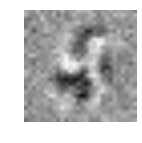

step 110 -- dloss: -0.164156734943, gloss: 0.422573238611
step 120 -- dloss: -0.137285798788, gloss: 0.389695554972
step 130 -- dloss: -0.173128306866, gloss: 0.475223004818
step 140 -- dloss: -0.18005245924, gloss: 0.467042446136
step 150 -- dloss: -0.164700657129, gloss: 0.440233200788
step 160 -- dloss: -0.205444291234, gloss: 0.421528041363
step 170 -- dloss: -0.171421647072, gloss: 0.440041691065
step 180 -- dloss: -0.187324613333, gloss: 0.450986921787
step 190 -- dloss: -0.176480397582, gloss: 0.41008284688
step 200 -- dloss: -0.176562517881, gloss: 0.430529862642


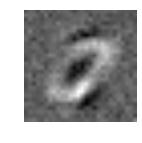

step 210 -- dloss: -0.180855378509, gloss: 0.424900263548
step 220 -- dloss: -0.147391960025, gloss: 0.367859244347
step 230 -- dloss: -0.167804688215, gloss: 0.429193288088
step 240 -- dloss: -0.159066170454, gloss: 0.392355799675
step 250 -- dloss: -0.178247302771, gloss: 0.428400784731
step 260 -- dloss: -0.146521359682, gloss: 0.402384668589
step 270 -- dloss: -0.171554416418, gloss: 0.413910925388
step 280 -- dloss: -0.122737422585, gloss: 0.371391743422
step 290 -- dloss: -0.164558857679, gloss: 0.416604906321
step 300 -- dloss: -0.16713398695, gloss: 0.409939706326


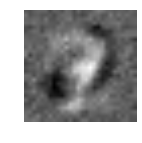

step 310 -- dloss: -0.148604542017, gloss: 0.369360029697
step 320 -- dloss: -0.15518938005, gloss: 0.387886941433
step 330 -- dloss: -0.139433771372, gloss: 0.38317066431
step 340 -- dloss: -0.160437732935, gloss: 0.437475353479
step 350 -- dloss: -0.159597635269, gloss: 0.438087582588
step 360 -- dloss: -0.165656298399, gloss: 0.429300993681
step 370 -- dloss: -0.174596831203, gloss: 0.418770074844
step 380 -- dloss: -0.170229077339, gloss: 0.420913040638
step 390 -- dloss: -0.149003222585, gloss: 0.385442167521
step 400 -- dloss: -0.167323186994, gloss: 0.409493595362


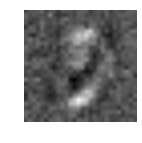

step 410 -- dloss: -0.164775431156, gloss: 0.445393383503
step 420 -- dloss: -0.160236358643, gloss: 0.434338867664
step 430 -- dloss: -0.187293946743, gloss: 0.445965260267
step 440 -- dloss: -0.121381029487, gloss: 0.338705867529
step 450 -- dloss: -0.185282349586, gloss: 0.436969935894
step 460 -- dloss: -0.189925089478, gloss: 0.437828063965
step 470 -- dloss: -0.160808205605, gloss: 0.444108366966
step 480 -- dloss: -0.163808554411, gloss: 0.379406422377
step 490 -- dloss: -0.155125796795, gloss: 0.410804569721
step 500 -- dloss: -0.150223851204, gloss: 0.394283473492


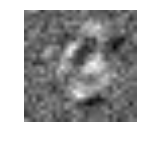

step 510 -- dloss: -0.167086079717, gloss: 0.406744688749
step 520 -- dloss: -0.14757797122, gloss: 0.406468868256
step 530 -- dloss: -0.195756927133, gloss: 0.433480769396
step 540 -- dloss: -0.15383413434, gloss: 0.409277558327
step 550 -- dloss: -0.164254486561, gloss: 0.432327717543
step 560 -- dloss: -0.16618219018, gloss: 0.459852874279
step 570 -- dloss: -0.205588966608, gloss: 0.419326305389
step 580 -- dloss: -0.134967237711, gloss: 0.342712342739
step 590 -- dloss: -0.188928157091, gloss: 0.453165203333
step 600 -- dloss: -0.155298143625, gloss: 0.449867069721


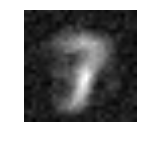

step 610 -- dloss: -0.166751980782, gloss: 0.406165421009
step 620 -- dloss: -0.130186021328, gloss: 0.465163946152
step 630 -- dloss: -0.13496863842, gloss: 0.388692528009
step 640 -- dloss: -0.165035486221, gloss: 0.430263161659
step 650 -- dloss: -0.159737825394, gloss: 0.39809218049
step 660 -- dloss: -0.179810881615, gloss: 0.443317174911
step 670 -- dloss: -0.172271817923, gloss: 0.451610833406
step 680 -- dloss: -0.177931457758, gloss: 0.413117587566
step 690 -- dloss: -0.156355172396, gloss: 0.478799730539
step 700 -- dloss: -0.13570073247, gloss: 0.415779560804


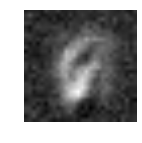

step 710 -- dloss: -0.139321625233, gloss: 0.396039098501
step 720 -- dloss: -0.145505428314, gloss: 0.417707324028
step 730 -- dloss: -0.164619833231, gloss: 0.446815758944
step 740 -- dloss: -0.132981881499, gloss: 0.369401097298
step 750 -- dloss: -0.152119457722, gloss: 0.396718531847
step 760 -- dloss: -0.171129450202, gloss: 0.410977393389
step 770 -- dloss: -0.16239720583, gloss: 0.388382405043
step 780 -- dloss: -0.15174728632, gloss: 0.410247772932
step 790 -- dloss: -0.180467039347, gloss: 0.435010313988
step 800 -- dloss: -0.14405092597, gloss: 0.406514763832


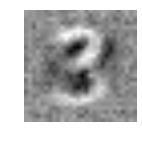

step 810 -- dloss: -0.129093229771, gloss: 0.401753485203
step 820 -- dloss: -0.160608291626, gloss: 0.44637799263
step 830 -- dloss: -0.181990787387, gloss: 0.428188472986
step 840 -- dloss: -0.164972454309, gloss: 0.408186227083
step 850 -- dloss: -0.113763809204, gloss: 0.391247332096
step 860 -- dloss: -0.134197354317, gloss: 0.403426140547
step 870 -- dloss: -0.126261740923, gloss: 0.369879722595
step 880 -- dloss: -0.182013303041, gloss: 0.453910470009
step 890 -- dloss: -0.20344504714, gloss: 0.466902166605
step 900 -- dloss: -0.181840702891, gloss: 0.41775110364


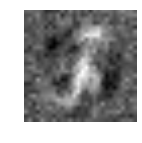

step 910 -- dloss: -0.160767436028, gloss: 0.396646142006
step 920 -- dloss: -0.179873019457, gloss: 0.459031194448
step 930 -- dloss: -0.169569849968, gloss: 0.482731878757
step 940 -- dloss: -0.169519200921, gloss: 0.400197654963
step 950 -- dloss: -0.189501553774, gloss: 0.443061798811
step 960 -- dloss: -0.15219143033, gloss: 0.41109842062
step 970 -- dloss: -0.174906402826, gloss: 0.441240996122
step 980 -- dloss: -0.199281394482, gloss: 0.450650572777
step 990 -- dloss: -0.149181604385, gloss: 0.326047331095
step 1000 -- dloss: -0.179281234741, gloss: 0.408513218164


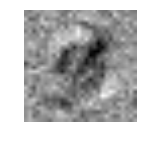

step 1010 -- dloss: -0.159315437078, gloss: 0.42656609416
step 1020 -- dloss: -0.145428791642, gloss: 0.384224385023
step 1030 -- dloss: -0.163295164704, gloss: 0.384663760662
step 1040 -- dloss: -0.17421618104, gloss: 0.410452514887
step 1050 -- dloss: -0.165549471974, gloss: 0.415017038584
step 1060 -- dloss: -0.148392230272, gloss: 0.43715852499
step 1070 -- dloss: -0.14288982749, gloss: 0.396592587233
step 1080 -- dloss: -0.160684794188, gloss: 0.386325746775
step 1090 -- dloss: -0.127032607794, gloss: 0.424327045679
step 1100 -- dloss: -0.158608853817, gloss: 0.447648108006


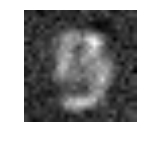

step 1110 -- dloss: -0.194939464331, gloss: 0.443851441145
step 1120 -- dloss: -0.156048774719, gloss: 0.381243675947
step 1130 -- dloss: -0.163369804621, gloss: 0.415790110826
step 1140 -- dloss: -0.168143212795, gloss: 0.414957582951
step 1150 -- dloss: -0.158609390259, gloss: 0.391631305218
step 1160 -- dloss: -0.174439430237, gloss: 0.48752835393
step 1170 -- dloss: -0.13114580512, gloss: 0.368840068579
step 1180 -- dloss: -0.132187992334, gloss: 0.424381941557
step 1190 -- dloss: -0.150797128677, gloss: 0.444199830294
step 1200 -- dloss: -0.139924913645, gloss: 0.41584160924


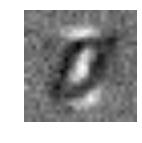

step 1210 -- dloss: -0.15653540194, gloss: 0.400934487581
step 1220 -- dloss: -0.181134223938, gloss: 0.423652291298
step 1230 -- dloss: -0.191235840321, gloss: 0.448569864035
step 1240 -- dloss: -0.131396383047, gloss: 0.42445909977
step 1250 -- dloss: -0.167321801186, gloss: 0.426527678967
step 1260 -- dloss: -0.179748207331, gloss: 0.434190750122
step 1270 -- dloss: -0.199744820595, gloss: 0.426118463278
step 1280 -- dloss: -0.181151151657, gloss: 0.465414047241
step 1290 -- dloss: -0.175917759538, gloss: 0.414157927036
step 1300 -- dloss: -0.190950125456, gloss: 0.459705591202


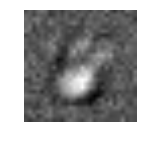

step 1310 -- dloss: -0.18382743001, gloss: 0.457840979099
step 1320 -- dloss: -0.182176977396, gloss: 0.428776204586
step 1330 -- dloss: -0.144917979836, gloss: 0.379320502281
step 1340 -- dloss: -0.15311421454, gloss: 0.390044182539
step 1350 -- dloss: -0.131888896227, gloss: 0.395385235548
step 1360 -- dloss: -0.161179751158, gloss: 0.424346536398
step 1370 -- dloss: -0.161529332399, gloss: 0.413527607918
step 1380 -- dloss: -0.151093646884, gloss: 0.37021446228
step 1390 -- dloss: -0.148312181234, gloss: 0.334631979465
step 1400 -- dloss: -0.171493321657, gloss: 0.428404092789


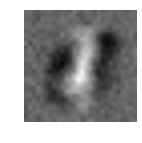

step 1410 -- dloss: -0.185815036297, gloss: 0.402247518301
step 1420 -- dloss: -0.20835468173, gloss: 0.46964481473
step 1430 -- dloss: -0.18671245873, gloss: 0.427552133799
step 1440 -- dloss: -0.181545913219, gloss: 0.407747894526
step 1450 -- dloss: -0.192475438118, gloss: 0.481683880091
step 1460 -- dloss: -0.132625967264, gloss: 0.383723497391
step 1470 -- dloss: -0.172117292881, gloss: 0.413598656654
step 1480 -- dloss: -0.158046841621, gloss: 0.420035928488
step 1490 -- dloss: -0.199046447873, gloss: 0.423174679279
step 1500 -- dloss: -0.148442342877, gloss: 0.371888816357


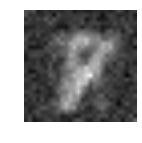

step 1510 -- dloss: -0.183905094862, gloss: 0.424638390541
step 1520 -- dloss: -0.167884334922, gloss: 0.411864906549
step 1530 -- dloss: -0.176394969225, gloss: 0.438517272472
step 1540 -- dloss: -0.172016635537, gloss: 0.391717374325
step 1550 -- dloss: -0.18295159936, gloss: 0.465729057789
step 1560 -- dloss: -0.161937355995, gloss: 0.377347797155
step 1570 -- dloss: -0.160537064075, gloss: 0.437666207552
step 1580 -- dloss: -0.166996926069, gloss: 0.392070144415
step 1590 -- dloss: -0.148189544678, gloss: 0.399989664555
step 1600 -- dloss: -0.184828281403, gloss: 0.393784850836


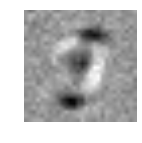

step 1610 -- dloss: -0.18161380291, gloss: 0.401201248169
step 1620 -- dloss: -0.191916242242, gloss: 0.391682744026
step 1630 -- dloss: -0.16504585743, gloss: 0.450837552547
step 1640 -- dloss: -0.178122073412, gloss: 0.449534922838
step 1650 -- dloss: -0.197770491242, gloss: 0.417294561863
step 1660 -- dloss: -0.181311637163, gloss: 0.408356100321
step 1670 -- dloss: -0.19192096591, gloss: 0.455130666494
step 1680 -- dloss: -0.182666510344, gloss: 0.480912357569
step 1690 -- dloss: -0.150109171867, gloss: 0.392155438662
step 1700 -- dloss: -0.136801064014, gloss: 0.405145674944


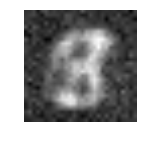

step 1710 -- dloss: -0.173194825649, gloss: 0.407448917627
step 1720 -- dloss: -0.143536031246, gloss: 0.396308124065
step 1730 -- dloss: -0.164513647556, gloss: 0.402333468199
step 1740 -- dloss: -0.162492722273, gloss: 0.40896832943
step 1750 -- dloss: -0.138844072819, gloss: 0.387084692717
step 1760 -- dloss: -0.178345739841, gloss: 0.435604691505
step 1770 -- dloss: -0.137031108141, gloss: 0.412522464991
step 1780 -- dloss: -0.170156553388, gloss: 0.380864202976
step 1790 -- dloss: -0.16972476244, gloss: 0.419087439775
step 1800 -- dloss: -0.177284359932, gloss: 0.403181135654


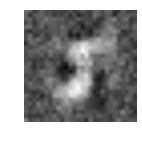

step 1810 -- dloss: -0.180703029037, gloss: 0.389327138662
step 1820 -- dloss: -0.177680432796, gloss: 0.426785558462
step 1830 -- dloss: -0.164508804679, gloss: 0.383808553219
step 1840 -- dloss: -0.168633162975, gloss: 0.483987182379
step 1850 -- dloss: -0.146870583296, gloss: 0.418572038412
step 1860 -- dloss: -0.125332117081, gloss: 0.373863458633
step 1870 -- dloss: -0.155933320522, gloss: 0.429738134146
step 1880 -- dloss: -0.172157049179, gloss: 0.44424533844
step 1890 -- dloss: -0.158764347434, gloss: 0.37579458952
step 1900 -- dloss: -0.161093682051, gloss: 0.442783564329


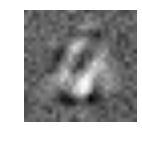

step 1910 -- dloss: -0.12798717618, gloss: 0.382839292288
step 1920 -- dloss: -0.168730050325, gloss: 0.456359326839
step 1930 -- dloss: -0.151844352484, gloss: 0.431011289358
step 1940 -- dloss: -0.145096361637, gloss: 0.435867398977
step 1950 -- dloss: -0.183834552765, gloss: 0.472562760115
step 1960 -- dloss: -0.186403632164, gloss: 0.435972720385
step 1970 -- dloss: -0.157338947058, gloss: 0.410697042942
step 1980 -- dloss: -0.153159171343, gloss: 0.40436565876
step 1990 -- dloss: -0.181725516915, gloss: 0.425993770361
step 2000 -- dloss: -0.177622228861, gloss: 0.449946850538


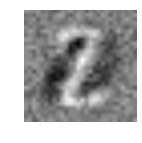

step 2010 -- dloss: -0.133580327034, gloss: 0.436995774508
step 2020 -- dloss: -0.129633545876, gloss: 0.412436008453
step 2030 -- dloss: -0.205590859056, gloss: 0.445623785257
step 2040 -- dloss: -0.145132422447, gloss: 0.401543855667
step 2050 -- dloss: -0.16997627914, gloss: 0.401558279991
step 2060 -- dloss: -0.158353686333, gloss: 0.408785432577
step 2070 -- dloss: -0.164310693741, gloss: 0.425760090351
step 2080 -- dloss: -0.156073391438, gloss: 0.403424888849
step 2090 -- dloss: -0.155231505632, gloss: 0.413300395012
step 2100 -- dloss: -0.177666932344, gloss: 0.425378710032


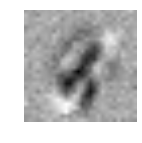

step 2110 -- dloss: -0.177786186337, gloss: 0.408014148474
step 2120 -- dloss: -0.189439564943, gloss: 0.402779698372
step 2130 -- dloss: -0.11053109169, gloss: 0.410308748484
step 2140 -- dloss: -0.162050813437, gloss: 0.389390528202
step 2150 -- dloss: -0.172952398658, gloss: 0.420159310102
step 2160 -- dloss: -0.155560493469, gloss: 0.391275763512
step 2170 -- dloss: -0.137480095029, gloss: 0.351424843073
step 2180 -- dloss: -0.138036370277, gloss: 0.405238986015
step 2190 -- dloss: -0.185672402382, gloss: 0.46093288064
step 2200 -- dloss: -0.177366018295, gloss: 0.408318608999


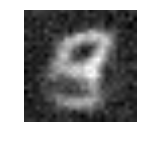

step 2210 -- dloss: -0.193754136562, gloss: 0.452246963978
step 2220 -- dloss: -0.161277085543, gloss: 0.429698288441
step 2230 -- dloss: -0.167106330395, gloss: 0.439125478268
step 2240 -- dloss: -0.172287493944, gloss: 0.424515485764
step 2250 -- dloss: -0.171662122011, gloss: 0.43760663271
step 2260 -- dloss: -0.199579924345, gloss: 0.445589065552
step 2270 -- dloss: -0.177233934402, gloss: 0.426679164171
step 2280 -- dloss: -0.162405222654, gloss: 0.436592280865
step 2290 -- dloss: -0.164056703448, gloss: 0.394367158413
step 2300 -- dloss: -0.192841887474, gloss: 0.445951342583


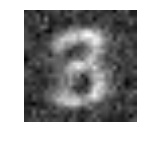

step 2310 -- dloss: -0.193314313889, gloss: 0.444880872965
step 2320 -- dloss: -0.186023712158, gloss: 0.445291787386
step 2330 -- dloss: -0.180672377348, gloss: 0.453198373318
step 2340 -- dloss: -0.15185251832, gloss: 0.391704440117
step 2350 -- dloss: -0.171585172415, gloss: 0.453583389521
step 2360 -- dloss: -0.152254492044, gloss: 0.440313994884
step 2370 -- dloss: -0.191071182489, gloss: 0.446503549814
step 2380 -- dloss: -0.149606108665, gloss: 0.437767803669
step 2390 -- dloss: -0.165051937103, gloss: 0.417481929064
step 2400 -- dloss: -0.161089882255, gloss: 0.387683540583


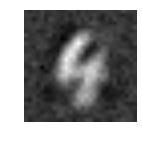

step 2410 -- dloss: -0.195820063353, gloss: 0.443559467793
step 2420 -- dloss: -0.197610855103, gloss: 0.450721740723
step 2430 -- dloss: -0.197069942951, gloss: 0.445076674223
step 2440 -- dloss: -0.150307178497, gloss: 0.395357429981
step 2450 -- dloss: -0.167975902557, gloss: 0.45464861393
step 2460 -- dloss: -0.150698453188, gloss: 0.405900031328
step 2470 -- dloss: -0.211059480906, gloss: 0.488393843174
step 2480 -- dloss: -0.187720745802, gloss: 0.426344364882
step 2490 -- dloss: -0.154249235988, gloss: 0.398233056068
step 2500 -- dloss: -0.155161648989, gloss: 0.403682857752


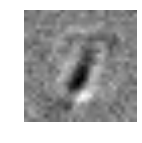

step 2510 -- dloss: -0.197990864515, gloss: 0.453244358301
step 2520 -- dloss: -0.167865484953, gloss: 0.418190956116
step 2530 -- dloss: -0.163791626692, gloss: 0.452678978443
step 2540 -- dloss: -0.185854047537, gloss: 0.479505628347
step 2550 -- dloss: -0.175030171871, gloss: 0.467619329691
step 2560 -- dloss: -0.17292265594, gloss: 0.38202136755
step 2570 -- dloss: -0.18940231204, gloss: 0.459568619728
step 2580 -- dloss: -0.136735409498, gloss: 0.396822333336
step 2590 -- dloss: -0.173028230667, gloss: 0.434201776981
step 2600 -- dloss: -0.172083586454, gloss: 0.443243145943


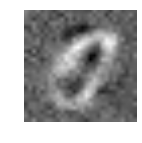

step 2610 -- dloss: -0.207977607846, gloss: 0.445908248425
step 2620 -- dloss: -0.181383222342, gloss: 0.440887123346
step 2630 -- dloss: -0.14094504714, gloss: 0.4031919837
step 2640 -- dloss: -0.200037896633, gloss: 0.433993607759
step 2650 -- dloss: -0.151920378208, gloss: 0.386125534773
step 2660 -- dloss: -0.13625138998, gloss: 0.367804378271
step 2670 -- dloss: -0.152097195387, gloss: 0.424985766411
step 2680 -- dloss: -0.156088650227, gloss: 0.413241118193
step 2690 -- dloss: -0.173236042261, gloss: 0.44673922658
step 2700 -- dloss: -0.141408592463, gloss: 0.427226364613


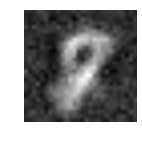

step 2710 -- dloss: -0.149070382118, gloss: 0.422134101391
step 2720 -- dloss: -0.179311126471, gloss: 0.490843206644
step 2730 -- dloss: -0.136169284582, gloss: 0.352895915508
step 2740 -- dloss: -0.200467363, gloss: 0.410510987043
step 2750 -- dloss: -0.209207966924, gloss: 0.443535923958
step 2760 -- dloss: -0.177441313863, gloss: 0.419376969337
step 2770 -- dloss: -0.162065118551, gloss: 0.445304602385
step 2780 -- dloss: -0.170518234372, gloss: 0.404481142759
step 2790 -- dloss: -0.1775418818, gloss: 0.464919894934
step 2800 -- dloss: -0.1895391047, gloss: 0.444613188505


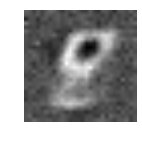

step 2810 -- dloss: -0.188547998667, gloss: 0.458258658648
step 2820 -- dloss: -0.197359293699, gloss: 0.461390197277
step 2830 -- dloss: -0.168100580573, gloss: 0.403871715069
step 2840 -- dloss: -0.140283182263, gloss: 0.377398639917
step 2850 -- dloss: -0.143030717969, gloss: 0.35634803772
step 2860 -- dloss: -0.19188067317, gloss: 0.435821592808
step 2870 -- dloss: -0.172339767218, gloss: 0.422308444977
step 2880 -- dloss: -0.173471912742, gloss: 0.416489124298
step 2890 -- dloss: -0.161671847105, gloss: 0.441398799419
step 2900 -- dloss: -0.166263431311, gloss: 0.3943772614


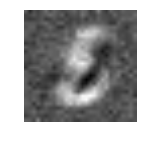

step 2910 -- dloss: -0.152124643326, gloss: 0.411745667458
step 2920 -- dloss: -0.129233807325, gloss: 0.414867401123
step 2930 -- dloss: -0.188770696521, gloss: 0.424075692892
step 2940 -- dloss: -0.184337720275, gloss: 0.428413301706
step 2950 -- dloss: -0.133220762014, gloss: 0.392563819885
step 2960 -- dloss: -0.164263188839, gloss: 0.415983110666
step 2970 -- dloss: -0.183340623975, gloss: 0.398983329535
step 2980 -- dloss: -0.155538409948, gloss: 0.405074894428
step 2990 -- dloss: -0.187563240528, gloss: 0.429388821125
step 3000 -- dloss: -0.147508248687, gloss: 0.383064687252


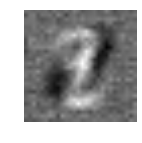

step 3010 -- dloss: -0.16243276, gloss: 0.416195690632
step 3020 -- dloss: -0.155817359686, gloss: 0.388375282288
step 3030 -- dloss: -0.148759037256, gloss: 0.454393208027
step 3040 -- dloss: -0.159979224205, gloss: 0.434121310711
step 3050 -- dloss: -0.169076651335, gloss: 0.426905184984
step 3060 -- dloss: -0.200997874141, gloss: 0.41818779707
step 3070 -- dloss: -0.163584262133, gloss: 0.419694006443
step 3080 -- dloss: -0.170811384916, gloss: 0.403004169464
step 3090 -- dloss: -0.172238066792, gloss: 0.410526841879
step 3100 -- dloss: -0.164742603898, gloss: 0.393815219402


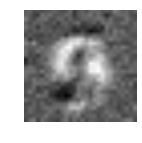

step 3110 -- dloss: -0.163893386722, gloss: 0.398896038532
step 3120 -- dloss: -0.150646299124, gloss: 0.403659790754
step 3130 -- dloss: -0.189831405878, gloss: 0.45621407032
step 3140 -- dloss: -0.15566894412, gloss: 0.381367474794
step 3150 -- dloss: -0.210266977549, gloss: 0.445348352194
step 3160 -- dloss: -0.142613857985, gloss: 0.420911759138
step 3170 -- dloss: -0.195128366351, gloss: 0.419090867043
step 3180 -- dloss: -0.172667652369, gloss: 0.434894055128
step 3190 -- dloss: -0.180575668812, gloss: 0.449990183115
step 3200 -- dloss: -0.175896644592, gloss: 0.467956364155


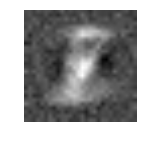

step 3210 -- dloss: -0.176827430725, gloss: 0.465476006269
step 3220 -- dloss: -0.124698877335, gloss: 0.388457119465
step 3230 -- dloss: -0.134315386415, gloss: 0.381453484297
step 3240 -- dloss: -0.18262578547, gloss: 0.428672850132
step 3250 -- dloss: -0.181902319193, gloss: 0.428306251764
step 3260 -- dloss: -0.157199025154, gloss: 0.423516631126
step 3270 -- dloss: -0.123599976301, gloss: 0.363850593567
step 3280 -- dloss: -0.174191504717, gloss: 0.458933144808
step 3290 -- dloss: -0.168727070093, gloss: 0.369978934526
step 3300 -- dloss: -0.183091253042, gloss: 0.456966817379


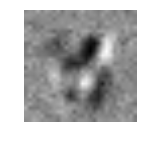

step 3310 -- dloss: -0.167206406593, gloss: 0.396312862635
step 3320 -- dloss: -0.149696871638, gloss: 0.398818790913
step 3330 -- dloss: -0.181560605764, gloss: 0.458871811628
step 3340 -- dloss: -0.184395626187, gloss: 0.40214279294
step 3350 -- dloss: -0.155214160681, gloss: 0.450550884008
step 3360 -- dloss: -0.146331936121, gloss: 0.392063438892
step 3370 -- dloss: -0.177839875221, gloss: 0.458948642015
step 3380 -- dloss: -0.176813542843, gloss: 0.394231975079
step 3390 -- dloss: -0.163023471832, gloss: 0.41454705596
step 3400 -- dloss: -0.171447977424, gloss: 0.405568003654


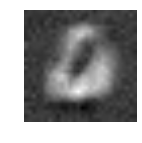

step 3410 -- dloss: -0.186577171087, gloss: 0.447173267603
step 3420 -- dloss: -0.153769612312, gloss: 0.426361829042
step 3430 -- dloss: -0.152570605278, gloss: 0.405134856701
step 3440 -- dloss: -0.133152037859, gloss: 0.417782247066
step 3450 -- dloss: -0.15687802434, gloss: 0.420795023441
step 3460 -- dloss: -0.143697172403, gloss: 0.403326451778
step 3470 -- dloss: -0.136002004147, gloss: 0.392400771379
step 3480 -- dloss: -0.16137227416, gloss: 0.42990475893
step 3490 -- dloss: -0.154940932989, gloss: 0.428815543652
step 3500 -- dloss: -0.173115313053, gloss: 0.446995586157


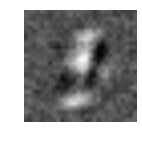

step 3510 -- dloss: -0.16472902894, gloss: 0.462463140488
step 3520 -- dloss: -0.196491956711, gloss: 0.455191522837
step 3530 -- dloss: -0.139761477709, gloss: 0.422497302294
step 3540 -- dloss: -0.201377630234, gloss: 0.45902711153
step 3550 -- dloss: -0.177277803421, gloss: 0.406139880419
step 3560 -- dloss: -0.155522540212, gloss: 0.391365259886
step 3570 -- dloss: -0.189986735582, gloss: 0.4859585464
step 3580 -- dloss: -0.190603151917, gloss: 0.43561309576
step 3590 -- dloss: -0.18580520153, gloss: 0.440449297428
step 3600 -- dloss: -0.150958895683, gloss: 0.375061094761


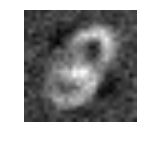

step 3610 -- dloss: -0.164272844791, gloss: 0.420482248068
step 3620 -- dloss: -0.178799122572, gloss: 0.418499827385
step 3630 -- dloss: -0.191705808043, gloss: 0.433744013309
step 3640 -- dloss: -0.147785171866, gloss: 0.38277888298
step 3650 -- dloss: -0.162653967738, gloss: 0.386730492115
step 3660 -- dloss: -0.163965702057, gloss: 0.421089470387
step 3670 -- dloss: -0.147044077516, gloss: 0.388311326504
step 3680 -- dloss: -0.156864374876, gloss: 0.42491286993
step 3690 -- dloss: -0.176961451769, gloss: 0.434731513262
step 3700 -- dloss: -0.174813315272, gloss: 0.423782080412


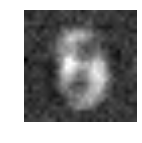

step 3710 -- dloss: -0.175593793392, gloss: 0.456369429827
step 3720 -- dloss: -0.123418360949, gloss: 0.348208844662
step 3730 -- dloss: -0.152561992407, gloss: 0.42859557271
step 3740 -- dloss: -0.151643931866, gloss: 0.379949361086
step 3750 -- dloss: -0.16375285387, gloss: 0.403971076012
step 3760 -- dloss: -0.167051911354, gloss: 0.397964775562
step 3770 -- dloss: -0.174439221621, gloss: 0.433388411999
step 3780 -- dloss: -0.159910947084, gloss: 0.450432181358
step 3790 -- dloss: -0.142291128635, gloss: 0.353668600321
step 3800 -- dloss: -0.177201002836, gloss: 0.440359771252


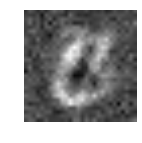

step 3810 -- dloss: -0.187976464629, gloss: 0.414965420961
step 3820 -- dloss: -0.194367468357, gloss: 0.446437478065
step 3830 -- dloss: -0.144527241588, gloss: 0.392606467009
step 3840 -- dloss: -0.173514455557, gloss: 0.423333197832
step 3850 -- dloss: -0.164869636297, gloss: 0.424710541964
step 3860 -- dloss: -0.158949479461, gloss: 0.372846573591
step 3870 -- dloss: -0.174250528216, gloss: 0.419434756041
step 3880 -- dloss: -0.162991061807, gloss: 0.397366017103
step 3890 -- dloss: -0.172500744462, gloss: 0.417724907398
step 3900 -- dloss: -0.1996986866, gloss: 0.473828315735


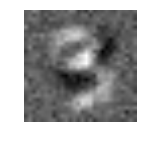

step 3910 -- dloss: -0.177534997463, gloss: 0.391675829887
step 3920 -- dloss: -0.196549057961, gloss: 0.452229887247
step 3930 -- dloss: -0.181366741657, gloss: 0.434379637241
step 3940 -- dloss: -0.178402841091, gloss: 0.464399069548
step 3950 -- dloss: -0.157761335373, gloss: 0.419228971004
step 3960 -- dloss: -0.211293369532, gloss: 0.435526788235
step 3970 -- dloss: -0.173651352525, gloss: 0.412925034761
step 3980 -- dloss: -0.164433091879, gloss: 0.454961240292
step 3990 -- dloss: -0.189156219363, gloss: 0.401963949203
step 4000 -- dloss: -0.216394752264, gloss: 0.44396725297


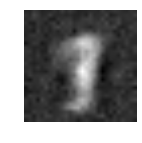

step 4010 -- dloss: -0.15845361352, gloss: 0.368510603905
step 4020 -- dloss: -0.176627039909, gloss: 0.463988602161
step 4030 -- dloss: -0.182237491012, gloss: 0.390031427145
step 4040 -- dloss: -0.166712850332, gloss: 0.433043539524
step 4050 -- dloss: -0.15350651741, gloss: 0.423687070608
step 4060 -- dloss: -0.144373327494, gloss: 0.415805339813
step 4070 -- dloss: -0.188300058246, gloss: 0.433808475733
step 4080 -- dloss: -0.163029640913, gloss: 0.444828987122
step 4090 -- dloss: -0.166241019964, gloss: 0.402342170477
step 4100 -- dloss: -0.171938553452, gloss: 0.396724700928


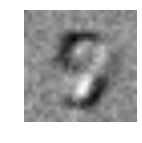

step 4110 -- dloss: -0.196162477136, gloss: 0.435350328684
step 4120 -- dloss: -0.155152291059, gloss: 0.446068704128
step 4130 -- dloss: -0.171609073877, gloss: 0.425652831793
step 4140 -- dloss: -0.158757507801, gloss: 0.420677870512
step 4150 -- dloss: -0.187378555536, gloss: 0.444800257683
step 4160 -- dloss: -0.165104836226, gloss: 0.42538484931
step 4170 -- dloss: -0.163795143366, gloss: 0.442283153534
step 4180 -- dloss: -0.200116783381, gloss: 0.493738412857
step 4190 -- dloss: -0.176047965884, gloss: 0.415396392345
step 4200 -- dloss: -0.190251246095, gloss: 0.412742376328


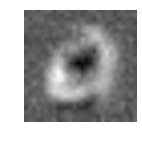

step 4210 -- dloss: -0.159410536289, gloss: 0.410990715027
step 4220 -- dloss: -0.132535517216, gloss: 0.423963069916
step 4230 -- dloss: -0.185787960887, gloss: 0.394578099251
step 4240 -- dloss: -0.181005448103, gloss: 0.443315058947
step 4250 -- dloss: -0.165293991566, gloss: 0.434181928635
step 4260 -- dloss: -0.158051967621, gloss: 0.43593287468
step 4270 -- dloss: -0.189569607377, gloss: 0.423269093037
step 4280 -- dloss: -0.208036839962, gloss: 0.483349502087
step 4290 -- dloss: -0.18166847527, gloss: 0.431205302477
step 4300 -- dloss: -0.158307671547, gloss: 0.417774200439


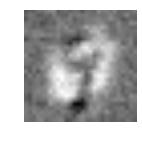

step 4310 -- dloss: -0.15348470211, gloss: 0.460100740194
step 4320 -- dloss: -0.182500660419, gloss: 0.438028663397
step 4330 -- dloss: -0.189045846462, gloss: 0.421834230423
step 4340 -- dloss: -0.188095346093, gloss: 0.430204480886
step 4350 -- dloss: -0.166337758303, gloss: 0.424731016159
step 4360 -- dloss: -0.156238943338, gloss: 0.415755569935
step 4370 -- dloss: -0.188245624304, gloss: 0.434722870588
step 4380 -- dloss: -0.176501274109, gloss: 0.443217456341
step 4390 -- dloss: -0.175981625915, gloss: 0.420255839825
step 4400 -- dloss: -0.195031434298, gloss: 0.47689345479


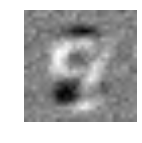

step 4410 -- dloss: -0.136065214872, gloss: 0.368094652891
step 4420 -- dloss: -0.194907873869, gloss: 0.4445746243
step 4430 -- dloss: -0.204180121422, gloss: 0.463837385178
step 4440 -- dloss: -0.174330323935, gloss: 0.406676948071
step 4450 -- dloss: -0.165633529425, gloss: 0.413626819849
step 4460 -- dloss: -0.14768114686, gloss: 0.420456796885
step 4470 -- dloss: -0.147913068533, gloss: 0.417317390442
step 4480 -- dloss: -0.166281253099, gloss: 0.427594572306
step 4490 -- dloss: -0.151593863964, gloss: 0.421155899763
step 4500 -- dloss: -0.164228931069, gloss: 0.402745038271


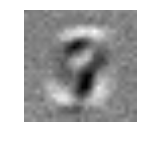

step 4510 -- dloss: -0.166847974062, gloss: 0.420878350735
step 4520 -- dloss: -0.180612981319, gloss: 0.408097147942
step 4530 -- dloss: -0.160627931356, gloss: 0.44891667366
step 4540 -- dloss: -0.159803077579, gloss: 0.405793905258
step 4550 -- dloss: -0.167094677687, gloss: 0.448909968138
step 4560 -- dloss: -0.135123640299, gloss: 0.431132376194
step 4570 -- dloss: -0.179689958692, gloss: 0.376689791679
step 4580 -- dloss: -0.175746932626, gloss: 0.413643598557
step 4590 -- dloss: -0.170412242413, gloss: 0.43003898859
step 4600 -- dloss: -0.172381907701, gloss: 0.374556332827


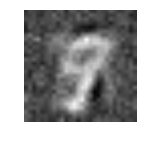

step 4610 -- dloss: -0.162591248751, gloss: 0.405066221952
step 4620 -- dloss: -0.171985000372, gloss: 0.375892430544
step 4630 -- dloss: -0.155911982059, gloss: 0.370528995991
step 4640 -- dloss: -0.153467476368, gloss: 0.414631962776
step 4650 -- dloss: -0.159850537777, gloss: 0.410783022642
step 4660 -- dloss: -0.141996502876, gloss: 0.371218264103
step 4670 -- dloss: -0.183739796281, gloss: 0.406971186399
step 4680 -- dloss: -0.158795714378, gloss: 0.410350382328
step 4690 -- dloss: -0.180260434747, gloss: 0.429696530104
step 4700 -- dloss: -0.179064184427, gloss: 0.399196147919


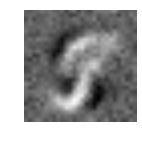

step 4710 -- dloss: -0.146398246288, gloss: 0.473167449236
step 4720 -- dloss: -0.138463675976, gloss: 0.427131146193
step 4730 -- dloss: -0.14938890934, gloss: 0.407686233521
step 4740 -- dloss: -0.180811613798, gloss: 0.431979119778
step 4750 -- dloss: -0.18479591608, gloss: 0.46814340353
step 4760 -- dloss: -0.15152400732, gloss: 0.419088721275
step 4770 -- dloss: -0.179242253304, gloss: 0.444623202085
step 4780 -- dloss: -0.168467283249, gloss: 0.451540738344
step 4790 -- dloss: -0.169629588723, gloss: 0.411437094212
step 4800 -- dloss: -0.184364706278, gloss: 0.412600129843


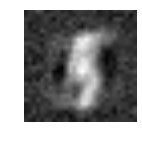

step 4810 -- dloss: -0.172575965524, gloss: 0.419955015182
step 4820 -- dloss: -0.227547094226, gloss: 0.472530156374
step 4830 -- dloss: -0.171690911055, gloss: 0.504255354404
step 4840 -- dloss: -0.154874891043, gloss: 0.386426240206
step 4850 -- dloss: -0.154162347317, gloss: 0.405724257231
step 4860 -- dloss: -0.144854724407, gloss: 0.398826062679
step 4870 -- dloss: -0.170219004154, gloss: 0.417126506567
step 4880 -- dloss: -0.167603701353, gloss: 0.427966862917
step 4890 -- dloss: -0.1717556566, gloss: 0.412213087082
step 4900 -- dloss: -0.157209485769, gloss: 0.479304105043


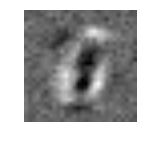

step 4910 -- dloss: -0.208535164595, gloss: 0.474487125874
step 4920 -- dloss: -0.145687431097, gloss: 0.417896658182
step 4930 -- dloss: -0.183111429214, gloss: 0.441165864468
step 4940 -- dloss: -0.240181833506, gloss: 0.493935763836
step 4950 -- dloss: -0.173062071204, gloss: 0.414174854755
step 4960 -- dloss: -0.216068714857, gloss: 0.457980841398
step 4970 -- dloss: -0.17896258831, gloss: 0.439734727144
step 4980 -- dloss: -0.218873858452, gloss: 0.508072137833
step 4990 -- dloss: -0.15225699544, gloss: 0.429152965546
step 5000 -- dloss: -0.193123698235, gloss: 0.420430511236


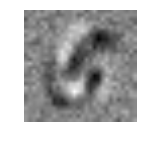

step 5010 -- dloss: -0.171851053834, gloss: 0.37289083004
step 5020 -- dloss: -0.174922451377, gloss: 0.413898140192
step 5030 -- dloss: -0.183956325054, gloss: 0.462307870388
step 5040 -- dloss: -0.195485174656, gloss: 0.451842814684
step 5050 -- dloss: -0.153945252299, gloss: 0.390925765038
step 5060 -- dloss: -0.171836644411, gloss: 0.445640772581
step 5070 -- dloss: -0.17236033082, gloss: 0.450947880745
step 5080 -- dloss: -0.210993587971, gloss: 0.478016376495
step 5090 -- dloss: -0.197401016951, gloss: 0.44428730011
step 5100 -- dloss: -0.183509498835, gloss: 0.448628783226


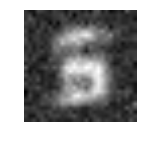

step 5110 -- dloss: -0.167603343725, gloss: 0.465970218182
step 5120 -- dloss: -0.205758959055, gloss: 0.500196695328
step 5130 -- dloss: -0.140847355127, gloss: 0.424489945173
step 5140 -- dloss: -0.158544823527, gloss: 0.395177096128
step 5150 -- dloss: -0.172266662121, gloss: 0.411786347628
step 5160 -- dloss: -0.150347322226, gloss: 0.410008281469
step 5170 -- dloss: -0.148322939873, gloss: 0.425065994263
step 5180 -- dloss: -0.18891865015, gloss: 0.488620579243
step 5190 -- dloss: -0.185880362988, gloss: 0.441214799881
step 5200 -- dloss: -0.205601796508, gloss: 0.453876793385


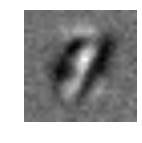

step 5210 -- dloss: -0.196449398994, gloss: 0.447324305773
step 5220 -- dloss: -0.123839169741, gloss: 0.389285475016
step 5230 -- dloss: -0.198529839516, gloss: 0.460302293301
step 5240 -- dloss: -0.203867226839, gloss: 0.466310232878
step 5250 -- dloss: -0.155923530459, gloss: 0.381409406662
step 5260 -- dloss: -0.172517448664, gloss: 0.402239650488
step 5270 -- dloss: -0.191353321075, gloss: 0.449779748917
step 5280 -- dloss: -0.18805269897, gloss: 0.417153388262
step 5290 -- dloss: -0.160284891725, gloss: 0.401169091463
step 5300 -- dloss: -0.138255596161, gloss: 0.405585020781


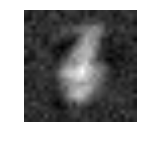

step 5310 -- dloss: -0.174268752337, gloss: 0.453638195992
step 5320 -- dloss: -0.175518423319, gloss: 0.433349430561
step 5330 -- dloss: -0.205796092749, gloss: 0.48003578186


KeyboardInterrupt: 

In [190]:
batch_size = 64

for _ in xrange(10000):
    
    for __ in xrange(5):
        x_batch, y_batch = dataset.next_batch(batch_size)
        feed = {x_d: x_batch.reshape(-1, 784), x_g: np.random.uniform(-1., 1., size=[batch_size, 1568])}
        sess.run(clip)
        sess.run(d_optimizer, feed_dict=feed)
    
    for __ in xrange(1):
        feed = {x_d: x_batch.reshape(-1, 784), x_g: np.random.uniform(-1., 1., size=[batch_size, 1568])}
        sess.run(g_optimizer, feed_dict=feed)
    
    if (_+1)%10 == 0:
        [dl, gl] = sess.run([d_loss, g_loss], feed_dict=feed)
        print("step {} -- dloss: {}, gloss: {}".format(_+1, dl, gl))
        
    if (_+1)%100 == 0:
        g = sess.run(g_sample, feed_dict=feed)
        showimg(g[1].reshape(28, 28, 1))

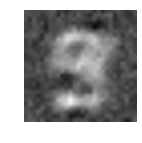

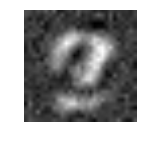

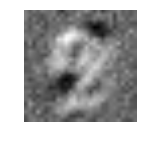

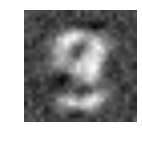

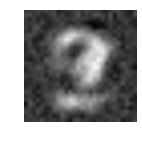

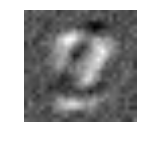

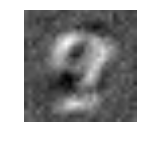

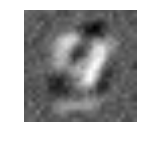

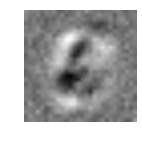

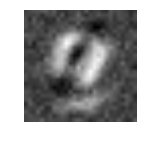

In [195]:
batch_size = 128
#feed = {z: np.random.randn(784*2).reshape(-1, 784*2)}
feed = {x_d: x_batch.reshape(-1, 784), x_g: np.random.uniform(0., 1., size=[batch_size, 1568])}

im = sess.run(g_sample, feed_dict=feed).reshape(-1, 28, 28, 1)
for i in xrange(10):
    showimg(im[i])

In [79]:

feed1 = {z: np.random.uniform(size=(3, 784*2)), y: 0*np.ones(3)}
feed2 = {G: dataset.next_batch(32), y: np.ones(32)}
print(sess.run(D, feed_dict=feed1))


NameError: name 'z' is not defined

In [86]:
sess.close()

In [ ]:
np.ones((1024, 1)).shape

In [ ]:
np.concatenate((label1, label0)).shape

In [48]:
tf.clip_by_value?

In [181]:
g[0].shape

(784,)

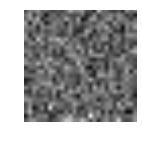

In [183]:
showimg(g[1].reshape(28, 28, 1))